# Short-Time Fourier Transformation

Fach: Signale und Systeme

Matrikelnummer: 4838168

*Notiz: im HTML Dokument dauert das initialisieren der interaktivien Widgets nachdem Sie den Button betätigt haben sehr lange. Bitte haben Sie Geduld*

In [10]:
import os
import numpy as np
import matplotlib
from  matplotlib import pyplot as plt
from ipywidgets import interact, fixed, FloatSlider, IntSlider
import scipy.signal
%matplotlib inline

## Idee

Mit der normalen Fourier Transformation eines Signals erhält man Informationen über den durchschnittlichen Frequenzgehalt des Signals über die gesamte Dauer. Es sagt jedoch nichts über den zeitlichen Verlauf der Frequenzen aus.

Durch die Short-Time Fourier Transformation (Teil der Fourier-Analyse) ist es möglich Aussagen über den Zeitpunkt der Frequenzen zu treffen. Das Ergebnis der STFT stellt die zeitliche Änderung des Frequenzspektrums dar. Hier wird nicht das gesamte Signal transformiert, sondern immer nur ein gewisser Ausschnitt des Signals (sogenanntes Fenster). Dieses Fenster wird über das gesamte Signal Stück für Stück geschoben und jeweils transformiert mitttels der Fourier Transformation. So erhält man durch die Fourier Transformation die Spektralbereiche für verschiedene Abschnitte des Signals. Die STFT stellt nun die Aneinanderreihung der Spektralbereiche im zeitlichen Verlauf dar.

## Beispielsignal für die folgenden Erklärungen

Wir verwenden für die kommenden Erklärungen ein Sinus-Signal, welches von 1 Hz auf 5 Hz in Sekunde 5 springt. An diesem Signal kann man einen Frequenzspruch beobachten und somit ist der zeitliche Verlauf des Frequenzspektrums gut untersuchbar.

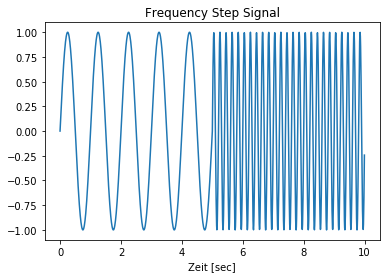

In [3]:
# Die Länge des Signals in Sekunden:
duration = 10
# Abtastrate des Signals in Hz
fs = 128
# Anzahl der "Abtastungen" innerhalb des gesamten Signals -> Länge des Arrays für das Signal
N = int(duration* fs)
# Erstellung des Zeitarrays für die Dauer des Signals und der entsprechenden Abstastfrequenz
time = np.arange(N) / fs

# laden eines Signals:
f1 = 1 # Frequenz zu Beginn
f2 = 5 # Sprung zur zweiten Frequenz f2
t1 = time[:N//2]
t2 = time[N//2:]
x1 = np.sin(2 * np.pi * f1 * t1)
x2 = np.sin(2 * np.pi * f2 * t2)
frequency_step_signal = np.concatenate((x1, x2))

plt.title('Frequency Step Signal')
plt.xlabel("Zeit [sec]")
plt.plot(time, frequency_step_signal)
plt.show()

## Wichtige Größen

Zwei Größen sind für die Durchführung der STFT entscheidend: <ul><li>Die Größe des Fenster (window_size) in Sekunden<li>Die Schrittweite zwischen zwei Fenstern (hop_size) in Sekunden</ul>

In jedem Schritt führt man die Fourier Transformation in dem Fenster mit der Fenstergröße window_size durch. Dieses Fenster wird für den nächsten Schritt um die hop_size nach rechts verschoben. Wenn die hop_size kleiner als die window_size ist, so überlappen sich die Fenster.

In [4]:
hop_size = 0.06
window_size = 1

## Schieben des Fensters

In der folgenden Simulation ist das Schieben des Fensters über das Signal zur Veranschaulichung dargestellt.
Mit dem Slider kann das Fenster verschoben werden (erst beim Loslassen wird die Fourier Transformation des Fensters durchgeführt). Auf der rechten Seite sieht man die Fourier Transformation des Fensters.

In [5]:
def fourier_transformation_of_window(time, signal, fs, window_pos, window_size):
    """
    Führt die Fourier Transformation für ein bestimmtes Fenster des Signals aus
    und gibt die jeweiligen Plot aus.
    
    Parameter:
        - time: Array der Zeit
        - signal: Array des Signals
        - fs: Abtastfrequenz
        - window_pos: Position des Fenster in Sekunden
        - window_size: Größe des Fensters in Sekunden
    """
    window_size = window_size * fs
    N = len(signal)
    window_pos_frames = int(fs * window_pos)
    window_function = np.zeros(N)
    # setzt die Stellen des Signals auf 1, die im Fenster liegen
    window_function[window_pos_frames : window_pos_frames + window_size] = 1
    # Durch die Multiplikation wird das Signal nur im Fenster ausgeschnitten
    signal = signal * window_function   
    
    # Plotten
    plt.figure(figsize=(10, 3))
    
    # windowed signal
    plt.subplot(1, 2, 1)
    plt.title("Windowed Signal")
    plt.plot(time, signal, c='k') # signal
    plt.plot(time, window_function, c='r') # window function in rot
    plt.xlim([min(time), max(time)])
    plt.ylim([-1.5, 1.5])
    plt.xlabel('Zeit [sec]')
    
    # Fourier Transformation von diesem Window
    plt.subplot(1, 2, 2)
    plt.title("Fourier Transformation of Window")
    
    X = np.abs(np.fft.fft(signal)) / fs # FT durchführen
    X = X[:N//2]
    freq = np.fft.fftfreq(N, d=1/fs)
    freq = freq[:N//2]
    
    plt.plot(freq, X, c='k')
    plt.xlim([0, 10])
    plt.ylim([0, 3])
    plt.xlabel('Frequenz [Hz]')
    plt.tight_layout()
    plt.show()
    
# window_size von 4 Sekunden
window_size = 4

# Inteaktive Simulation
interact(fourier_transformation_of_window,
         window_pos=FloatSlider(min=0, max=duration-(window_size), step=0.1, 
                continuous_update=False, value=2, description='Position'),
                time=fixed(time), signal=fixed(frequency_step_signal), fs=fixed(fs), window_size=fixed(window_size));

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='Position', max=6.0), Output…

## Implementierung der Short-Time Fourier Transformation

Für die Short-Time Fourier Transformation wird für jedes Fenster (der Größe window_size) die Fourier Transformation durchgeführt und in einem komplexen Array gespeichert. Durch die anschließende Quatrierung des Betrags wird der Array real und kann gezeichnet werden. Das Ergebnis wird in einem Spektogramm dargestellt.
In dieser Implementation wird die Zeitdiskrete Short Time Fourier Transformation durchgeführt. Sie wird durch folgende Formel realisiert:
$$X(m,w) = \sum_{n=-\infty}^\infty x[n] * w[n-m] * e^{-j\omega n}$$
mit dem Signal x[n], der Fensterfunktion w[n], Kreisfrequenz $\omega$ und dem Analysezeitpunkt m.

In [6]:
def stft(signal, window_size, hop_size, only_positive_frequencies=False):
    """
    Berechnet die Short-Time_fourier Transformation für ein gegebenes Signal

    Parameter:
        - signal: Signal auf dem STFT durchgeführt werden soll
        - window_size: Größe des Fensters in Sekunden
        - hop_size: Bestimmt den Abstand zwischen zwei Fensteranfängen in Sekunden
        - only_positive_frequencies: wenn auf True, dann wird nur der positive Part des Spektrums benutzt
    """
    window_size = int(window_size * fs)  # in Frames
    hop_size = int(hop_size * fs)
    N = len(signal)
    window_function = np.ones(window_size)
    # Wie viele Fenster benötigt werden, um das gesamte Signal abzudecken
    amount_of_windows = np.floor((N - window_size) / hop_size).astype(int) + 1
    # Das Ergebnis wird initialisiert. Die Größe wird dabei von der Größe eines Fensters und der Anzahl der Fenster über das gesamte Signal bestimmt
    # Komplex ist der Datentyp, da das Ergbnis der FFT einen komplexen Array zurückgibt
    stft_signal = np.zeros((window_size, amount_of_windows), dtype='complex')
    
    # Für jedes Fenster wird die Fourier Transformation durchgeführt
    for count in range(amount_of_windows):
        # Das Fenster wird innerhalb des Signals ausgeschnitten
        windowed_signal = signal[count * hop_size : count * hop_size + window_size] * window_function
        # Die Fourier transformation wird durchgeführt in diesem Fenster. Das Ergebnis ist komplex
        stft_window = np.fft.fft(windowed_signal)
        # Das Ergbnis wird nun in einer Spalte des Arrays gespeichert
        stft_signal[:, count] = stft_window
    
    # filtert positive Frequenzen
    if only_positive_frequencies:
        K = 1 + window_size // 2
        stft_signal = stft_signal[0:K, :]
    
    # Das spectrogram ist eine zwei-dimensionale Representation der quatrierten Magnitude der STFT:
    Y = np.abs(stft_signal) ** 2
    
    T_coef = np.arange(stft_signal.shape[1]) * hop_size / fs
    F_coef = np.arange(stft_signal.shape[0]) * fs / window_size

    left = min(T_coef)
    right = max(T_coef) + window_size / fs
    lower = min(F_coef)
    upper = max(F_coef)

    plt.imshow(Y, origin='lower', aspect='auto', 
               extent=[left, right, lower, upper])
    plt.ylim(0, 10)
    plt.xlabel('Zeit [sec]')
    plt.ylabel('Frequenz [Hz]')
    plt.tight_layout()

## Wie wähle ich die Fenstergröße? Küpfmüllersche Unbestimmtheitsrelation

Eine Eigenschaft der STFT ist die Küpfmüllersche Unbestimmtheitsrelation:
Sie beschreibt den Zusammenhang zwischen der Auflösung im Zeitbereich und der Auflösung im Frequenzbereich. das Produkt aus Zeit und Frequenz ist stets konstant. <ul><li>Möchte man zum Beispiel den genauen Zeitpunkt bestimmen, an dem eine Frequenz eingesetzt hat, so benötigt man eine hohe Auflösung im Zeitbereich. Dies hat jedoch zur Folge, dass der Frequenzbereich unscharf wird. Um dieses Szenario zu erreichen muss die Fenstergröße klein wählen.
<li>Möchte man jedoch die Frequenz genau bestimmen, muss die Fenstergröße groß gewählt werden, damit man eine hohe Auflösung im Frequenzbereich erreicht. Hierbei wird die Zeitauflösung jedoch ungenau.</ul>

Im Nachfolgenden sieht man diese Eigenschaft an einem Signal, indem die Frequnez zum Zeitpunkt t = 5 von 1 Hz auf 5 Hz springt:

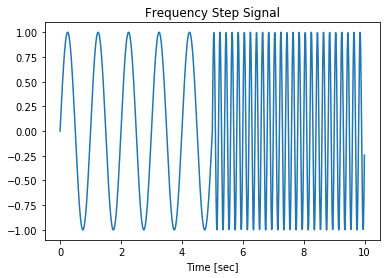

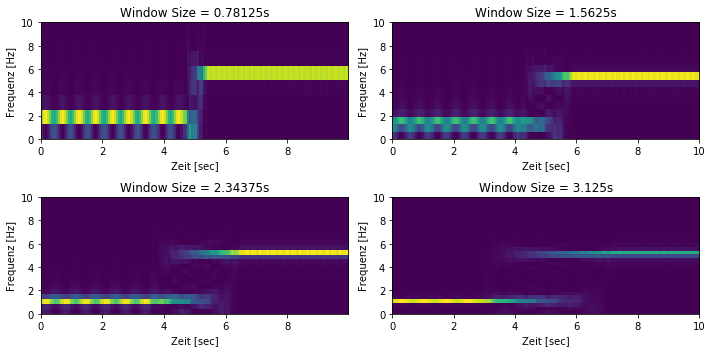

In [7]:
plt.title('Frequency Step Signal')
plt.plot(time, frequency_step_signal)
plt.xlabel("Time [sec]")
plt.show()

hop_size = 8 /fs
fs = 128

plt.figure(figsize=(10, 5))

for count in range(1,5):
    window_size = count * 100 / fs
    plt.subplot(2, 2, count)
    plt.title("Window Size = " + str(window_size) + "s")
    stft(frequency_step_signal, window_size, hop_size, only_positive_frequencies=True)

## Interaktive Simulation der Short-Time Fourier Analyse

Zuerst kann ein Signal ausgewählt und angepasst werden. Danach kann die Short-Time Fourier Transformation an diesem Signal durchgeführt werden. Dabei kann man die Window Size, Hop Size verändern, sowie nur positive Frequenzen filtern.

In [8]:
def set_signal_and_stft(signal_chosen, duration_chosen, window_size, hop_size, only_positive_frequencies):
    # Die Länge des Signals in Sekunden:
    duration = duration_chosen
    # Anzahl der "Abtastungen" innerhalb des gesamten Signals -> Länge des Arrays für das Signal
    N = int(duration* fs)
    # Erstellung des Zeitarrays für die Dauer des Signals und der entsprechenden Abstastfrequenz
    time = np.arange(N) / fs
    # obiges Beispielsignal als "Frequency Step Signal"
    
    if signal_chosen is 0:
        f1 = 1
        f2 = 5
        t1 = time[:N//2]
        t2 = time[N//2:]
        x1 = 1.0 * np.sin(2 * np.pi * f1 * t1)
        x2 = 0.7 * np.sin(2 * np.pi * f2 * t2)
        signal = np.concatenate((x1, x2))
    elif signal_chosen is 1:
        # Chirp Signal
        signal = scipy.signal.chirp(time, 6, 10, 1)
    elif signal_chosen is 2:
        # Sinus
        signal = np.sin(2 * np.pi * time)
    else:
        signal = frequency_step_signal
    plt.plot(time, signal)
    plt.show()
    
    stft(signal, window_size, hop_size, only_positive_frequencies)

interact(set_signal_and_stft,
        signal_chosen=[("Cirp Signal", 1), ("Frequency Step Signal", 0), ("Sinus", 2)],
        duration_chosen=FloatSlider(min=1, max=100, step=0.1, continuous_update=False, value=10, description='Duration'),
        window_size=FloatSlider(min=0.1, max=duration, step=0.1, continuous_update=False, value=3, description='Window Size'),
        hop_size=FloatSlider(min=0.01, max=3, step=0.01, continuous_update=False, value=0.06, description='Hop Size'),
        only_positive_frequencies=True);

interactive(children=(Dropdown(description='signal_chosen', options=(('Cirp Signal', 1), ('Frequency Step Sign…